# Tutorial for STL Design and Policy Learning

Imagine we have a ground robot moving in a 2D environment. The environment has an obstacle and a goal point. The goal is to reach the goal while not collide with the obstacle. We now show how to define the specifcation using STL and how to learn the policy using our STL library.

& {|♢[20:26] (REACH)|,|◻[0:26] (AVOID)|}
AND {|EVENTUALLY[20:26] (REACH)|,|ALWAYS[0:26] (AVOID)|}


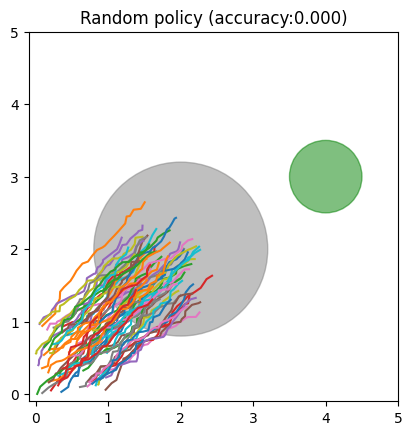

In [57]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from lib_stl_core import *  # import our core library (contained in a single file)
torch.manual_seed(1007)

# environment setup
nt = 25  # time horizon
DOF = 2  # degree of freedom
goal_x = 4  # define goal location
goal_y = 3
goal_r = 0.5
obs_x = 2  # define obstacle location
obs_y = 2
obs_r = 1.2

# hyperparameters
learning_rate = 3e-4
smoothing_factor = 500
batch_size = 64
n_iters = 1000

# system dynamics
def next_state(x, u):
    dt = 0.1
    new_x = torch.zeros_like(x)
    new_x[..., 0] = x[..., 0] + u[..., 0] * dt
    new_x[..., 1] = x[..., 1] + u[..., 1] * dt
    return new_x

# define how to generate trajectories
def roll_out_trajectory(init_x, us):
    nt = us.shape[1]
    trajs = [init_x]
    for ti in range(nt):
        x = trajs[-1]
        new_x = next_state(x, us[:, ti])
        trajs.append(new_x)
    return torch.stack(trajs, dim=1)

# plot to check the policy behavior/performance
def visualization(trajs, stl, title):
    ax = plt.gca()
    ax.add_patch(Circle([obs_x, obs_y], obs_r, color="gray", alpha=0.5))
    ax.add_patch(Circle([goal_x, goal_y], goal_r, color="green", alpha=0.5))
    trajs_d = trajs.detach()
    for i in range(trajs_d.shape[0]):
        plt.plot(trajs_d[i,:,0], trajs_d[i,:,1])
    plt.axis("scaled")
    plt.xlim(-0.1, 5)
    plt.ylim(-0.1, 5)
    acc = torch.mean((stl(trajs, smoothing_factor, d={"hard":True})[:, 0]>0).float())
    plt.title("%s (accuracy:%.3f)"%(title, acc))
    plt.show()

# define the STL using our stl library
# the AP defines the function to compute for the robustness score
Reach = Eventually(nt-5, nt, AP(lambda x: goal_r**2 - ((x[...,0]-goal_x)**2+(x[...,1]-goal_y)**2), comment="REACH"))
Avoid = Always(0, nt, AP(lambda x: (x[...,0]-obs_x)**2+(x[...,1]-obs_y)**2-obs_r**2, comment="AVOID"))
stl = ListAnd([Reach, Avoid])

# check the STL content
print(stl)
stl.update_format("word")
print(stl)

# check how a random policy goes
init_x = torch.rand(batch_size, DOF)
rand_us = torch.rand(batch_size, nt, 2)
rand_trajs = roll_out_trajectory(init_x, rand_us) 
visualization(rand_trajs, stl, "Random policy") 

iter:0000  loss:19.349  accuracy:0.000
iter:0100  loss:2.306  accuracy:0.000
iter:0200  loss:1.690  accuracy:0.000
iter:0300  loss:0.786  accuracy:0.141
iter:0400  loss:0.436  accuracy:0.734
iter:0500  loss:0.317  accuracy:1.000
iter:0600  loss:0.275  accuracy:1.000
iter:0700  loss:0.264  accuracy:1.000
iter:0800  loss:0.260  accuracy:1.000
iter:0900  loss:0.258  accuracy:1.000
Finished in 4.0724 seconds


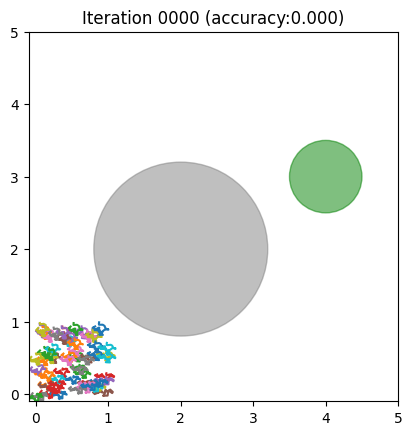

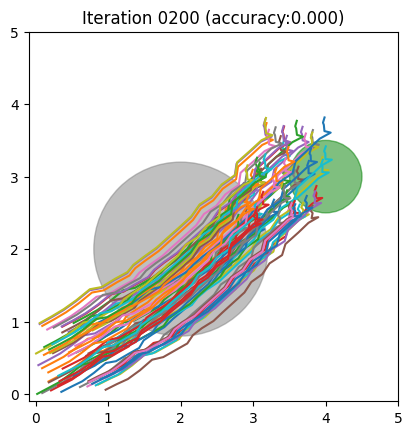

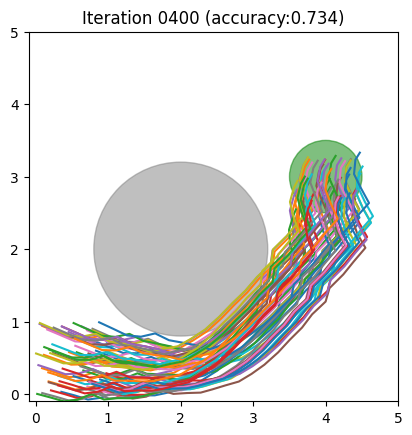

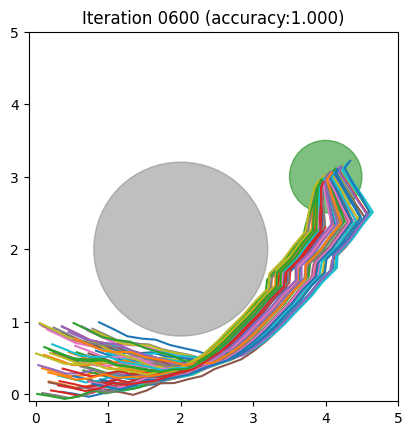

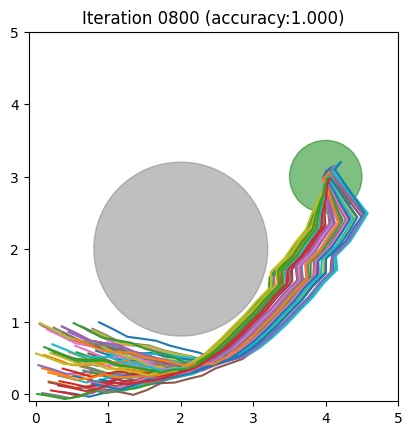

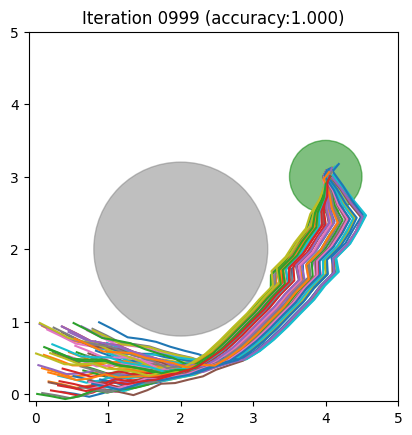

In [62]:
torch.manual_seed(1007)

# define the policy network
class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()
        self.net = nn.Sequential(
          nn.Linear(2, 64),
          nn.ReLU(),
          nn.Linear(64, 64),
          nn.ReLU(),
          nn.Linear(64, nt * DOF),
        )
    
    def forward(self, x):
        amin = -2
        amax = 2
        num_samples = x.shape[0]
        u = self.net(x)
        u = u.reshape(list(u.shape)[:-1]+[nt, DOF])
        return torch.tanh(u) * (amax - amin) / 2 + (amax  + amin) / 2

t1=time.time()
policy_net = PolicyNet()
optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)
trajs_list = []

# The training pipeline
for iter_i in range(n_iters):
    x0 = init_x.detach()
    us = policy_net(x0)
    trajs = roll_out_trajectory(x0, us)
    robustness_score = stl(trajs, smoothing_factor)[:, 0]
    accuracy = torch.mean((robustness_score>0).float())
    loss = torch.mean(torch.nn.functional.relu(0.5-robustness_score))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter_i % 100 == 0:
        print("iter:%04d  loss:%.3f  accuracy:%.3f"%(iter_i, loss.item(), accuracy.item()))
    if iter_i % 200 == 0 or iter_i == n_iters-1:
        trajs_list.append([iter_i,trajs.detach()])

t2=time.time()
print("Finished in %.4f seconds"%(t2-t1))

# plot the policy performance as training evolves
for iter_i, trajs in trajs_list:
    visualization(trajs, stl, "Iteration %04d"%(iter_i))